In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Import packages

from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [3]:
# Import train and test data

train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Exploring data

In [4]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
# What are our categorical and non categorical columns

print('Catergorical columns \n')
print(train_df.dtypes[train_df.dtypes == 'object'])

print('\n Numerical columns \n')
print(train_df.dtypes[train_df.dtypes != 'object'])



Catergorical columns 

MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      

For numerical features, lets plot correlation between them and SalePrice to look at trends abnd identify outliers to drop

In [7]:
numerical_features = train_df.dtypes[train_df.dtypes != 'object'].drop(['Id','SalePrice'])
print("Number of numerical features: ", len(numerical_features))

Number of numerical features:  36


# Numerical features vs Sale Price

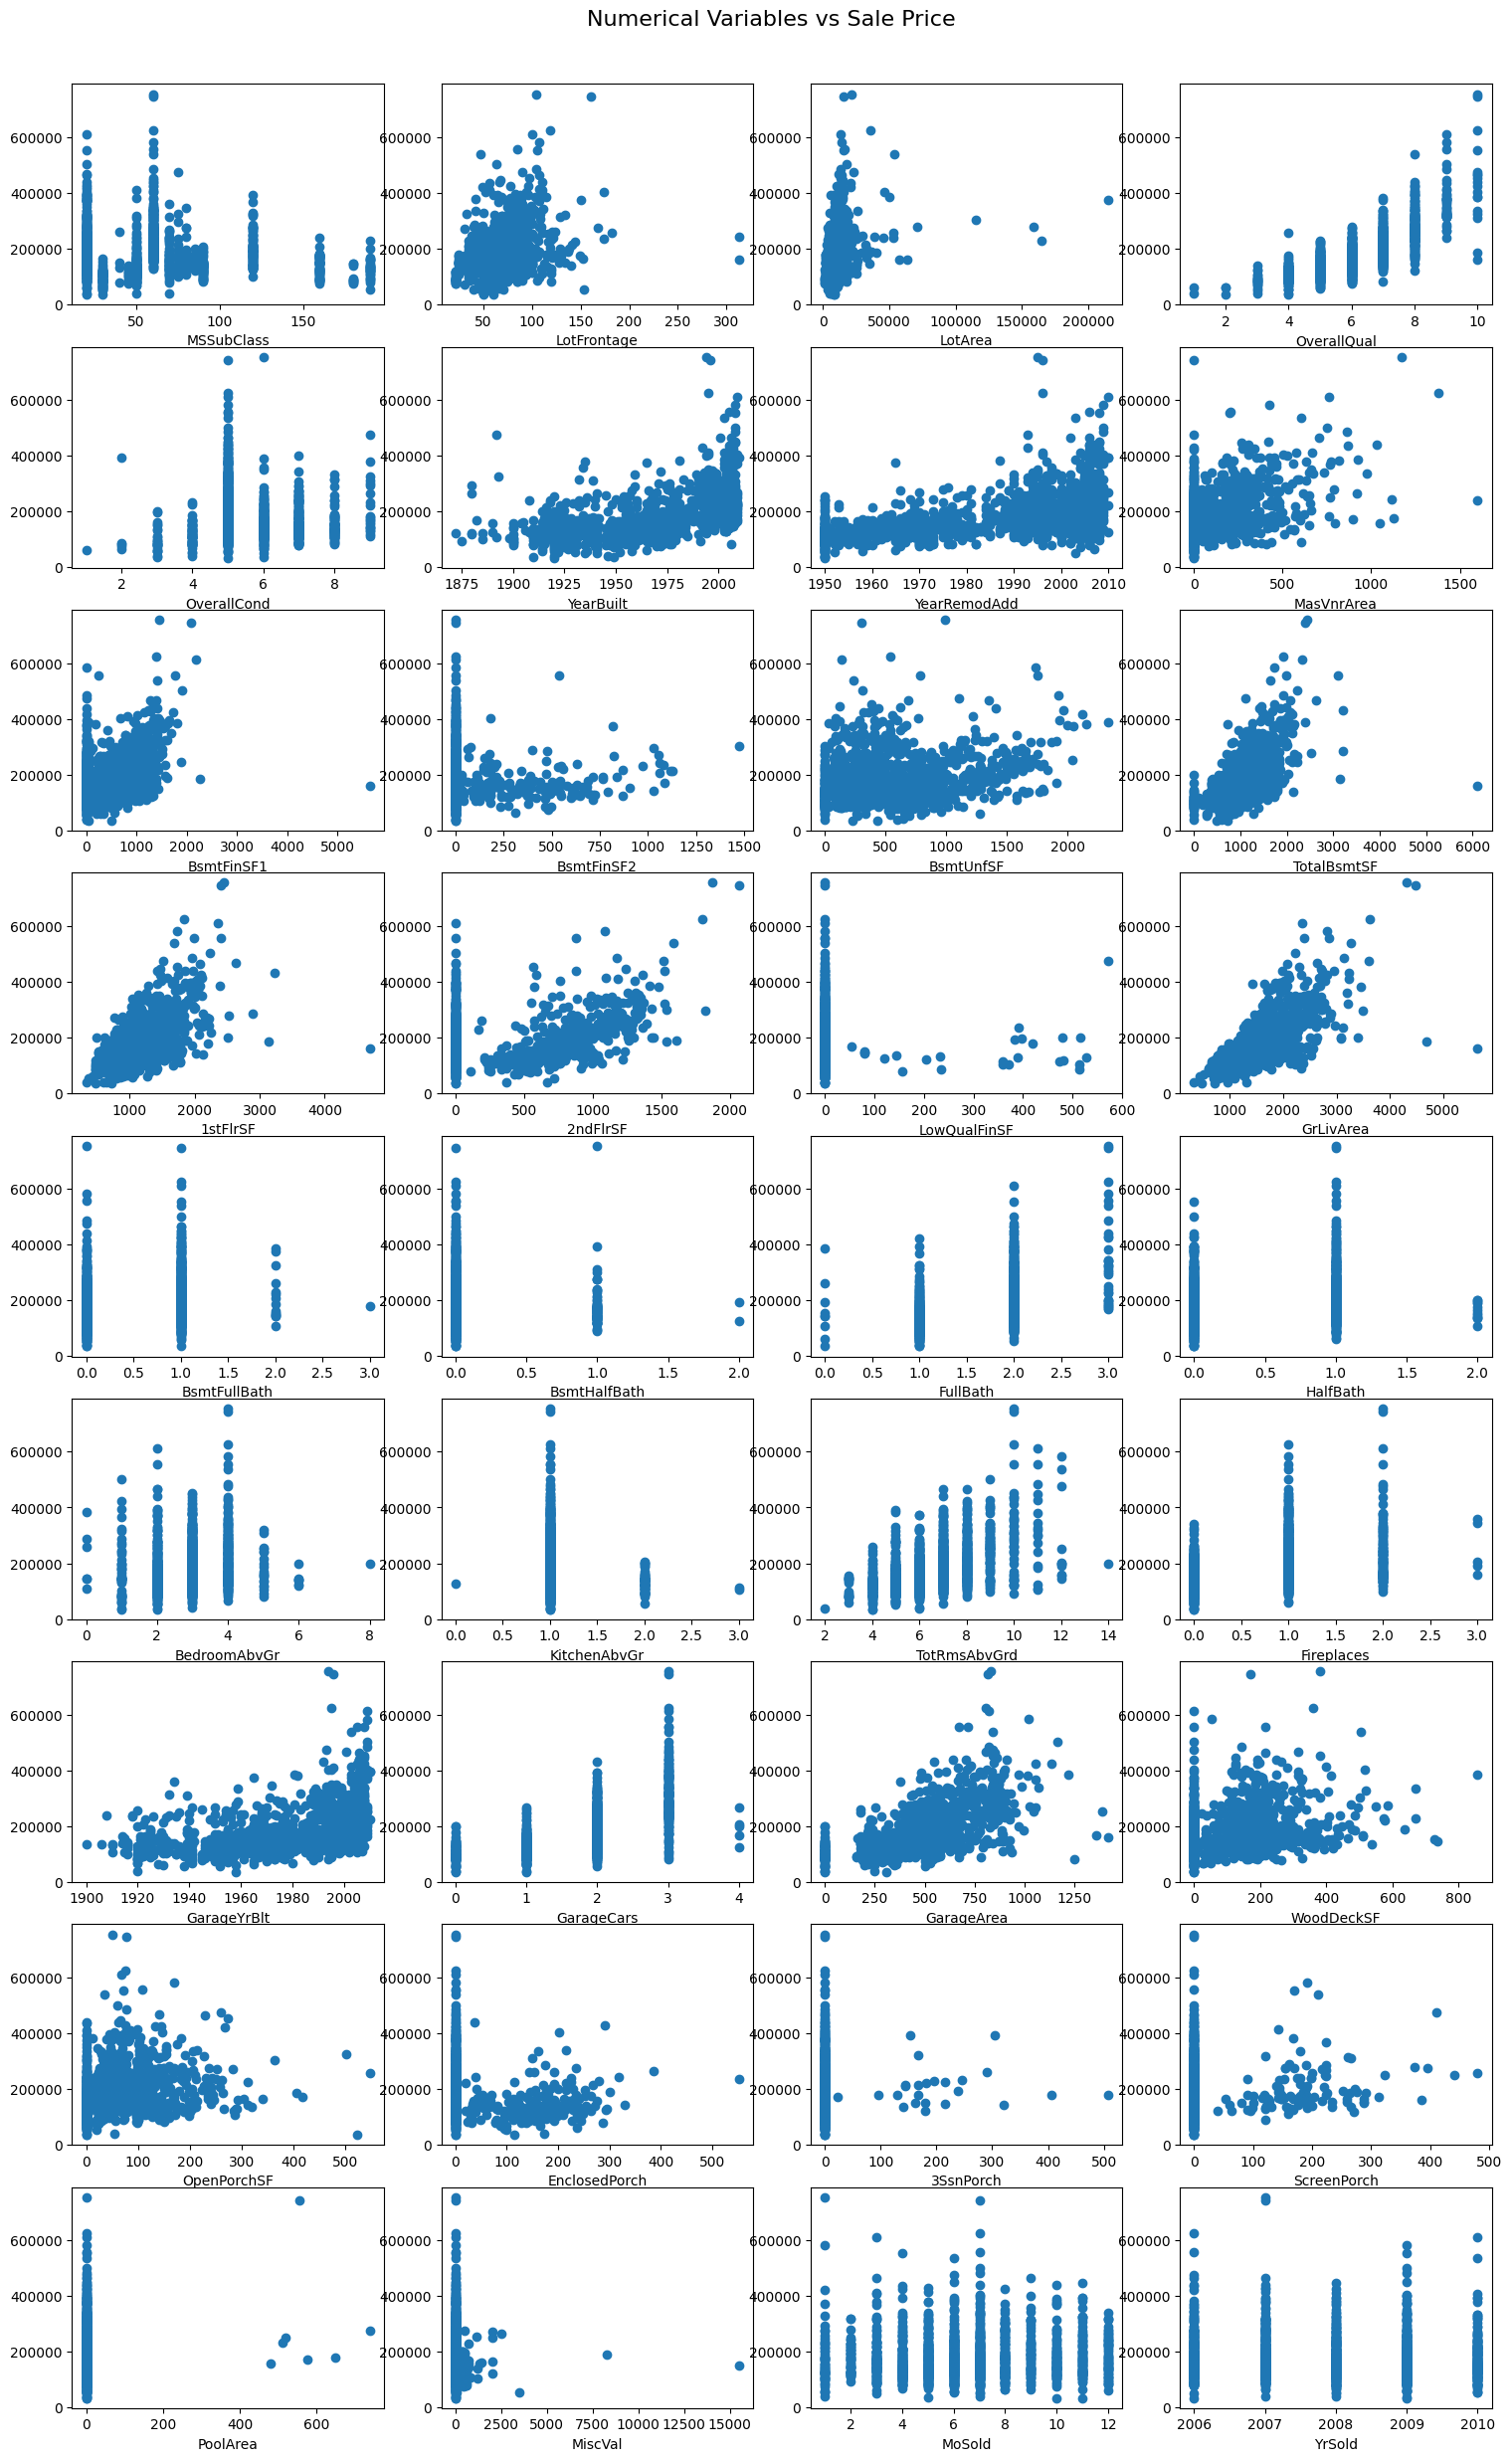

In [8]:
fig, axs = plt.subplots(9,4, figsize=(15,25))
plt.tight_layout()
for i in range(len(numerical_features)):
    axs[i//4,i%4].scatter(train_df[numerical_features.index[i]], train_df['SalePrice'])
    axs[i//4,i%4].set(xlabel=numerical_features.index[i])
plt.suptitle("Numerical Variables vs Sale Price", size=16)
fig.subplots_adjust(top=0.95)
plt.show()

# Removing outliers

We have visible outliers in a number of categories. Before removing them, let's also quantify how much of an outlier they are looking at their z-score

In [9]:
# Create array of ids we will remove from the dataset

ids = []

In [10]:
# Starting with Lot Frontage
# We can see our two values on the right of the graph have a zscore of 10, so big outliers

stats.zscore(train_df['LotFrontage'].dropna()).sort_values().tail(10)

313      3.293562
1211     3.375953
1337     3.417148
1182     3.705515
1107     4.035077
231      4.282249
197      4.282249
1127     4.611811
934     10.008389
1298    10.008389
Name: LotFrontage, dtype: float64

In [11]:
# Let's add those two ids to our list to drop

z = stats.zscore(train_df['LotFrontage'].dropna())
z_outliers = z[stats.zscore(train_df['LotFrontage'].dropna()) > 5]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935, 1299]

In [12]:
# Lets look at Lot Area
# Let's drop those where the zscore >10

stats.zscore(train_df['LotArea'].dropna()).sort_values().tail(10)

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
Name: LotArea, dtype: float64

In [13]:
# Let's add those two ids to our list to drop

z = stats.zscore(train_df['LotArea'].dropna())
z_outliers = z[stats.zscore(train_df['LotArea'].dropna()) > 10]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935, 1299, 250, 314, 336, 707]

In [14]:
# It looks like we have some outliers for where OverallCond = 2, 5 6, let's check those
# The z-score for the large value for where OverallCond=2 isn't that crazy, but that's because there are a small number of values. From the eye test it looks bad

print(stats.zscore(train_df[train_df['OverallCond'] == 2]['SalePrice']).sort_values().tail(4))
print(stats.zscore(train_df[train_df['OverallCond'] == 5]['SalePrice']).sort_values().tail(4))
print(stats.zscore(train_df[train_df['OverallCond'] == 6]['SalePrice']).sort_values().tail(4))

250   -0.518003
88    -0.450767
676   -0.434947
378    1.996867
Name: SalePrice, dtype: float64
803     4.464633
898     4.802302
1169    4.959158
1182    6.369836
Name: SalePrice, dtype: float64
654    3.234032
608    3.384154
688    3.926903
691    9.915289
Name: SalePrice, dtype: float64


In [15]:
# Add those ids to our ids list

for i in [2,5,6]:
    ids.append(train_df.iloc[train_df[train_df['OverallCond'] == i]['SalePrice'].sort_values().tail(1).index].Id.values[0])
ids


[935, 1299, 250, 314, 336, 707, 379, 1183, 692]

In [16]:
# Year built looks to have an outlier, where one house built before 1900 has a very high value
# This outlier has a score double that of its next highest, let's remove 

stats.zscore(train_df[train_df['YearBuilt'] < 1900]['SalePrice']).sort_values().tail(5)


991   -0.116855
747    0.802133
304    1.074334
583    1.355717
185    2.762632
Name: SalePrice, dtype: float64

In [17]:
# Append id

ids.append(train_df.iloc[train_df[train_df['YearBuilt'] <1900]['SalePrice'].sort_values().tail(1).index].Id.values[0])

In [18]:
# Let's look at the value YearRemodAdd, where there looks to be a outlier for a house here between 1960-70

stats.zscore(train_df.loc[(train_df['YearRemodAdd'] > 1960) & (train_df['YearRemodAdd'] < 1970)]['SalePrice']).sort_values().tail(5)

130     2.056376
335     2.132733
1250    2.522285
1423    3.323906
313     5.913064
Name: SalePrice, dtype: float64

In [19]:
# Let's add this id

index_outlier = stats.zscore(train_df.loc[(train_df['YearRemodAdd'] > 1960) & (train_df['YearRemodAdd'] < 1970)]['SalePrice']).sort_values().tail(1).index
ids.append(train_df.iloc[index_outlier].Id.values[0])

In [20]:
# Masvnrarea looks to have some outliers on the end, lets look at those
# Let's drop those where the zscore >7

stats.zscore(train_df['MasVnrArea'].dropna()).sort_values().tail(10)

517     4.515455
224     4.520980
981     4.813791
58      5.123177
808     5.211573
70      5.587256
115     5.664602
691     5.891116
1169    7.040263
297     8.266757
Name: MasVnrArea, dtype: float64

In [21]:
# Let's add those two ids to our list to drop

z = stats.zscore(train_df['MasVnrArea'].dropna())
z_outliers = z[stats.zscore(train_df['MasVnrArea'].dropna()) > 7]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 314, 298, 1170]

In [22]:
# BsmtFinSF1 looks to have some outliers on the end, lets look at those
# Let's drop those where the zscore >10

stats.zscore(train_df['BsmtFinSF1'].dropna()).sort_values().tail(10)

654      2.746754
664      2.801586
440      2.902476
53       2.996786
70       3.150315
178      3.202953
1182     3.624059
898      3.825839
523      3.983754
1298    11.405753
Name: BsmtFinSF1, dtype: float64

In [23]:
# Let's add those two ids to our list to drop

z = stats.zscore(train_df['BsmtFinSF1'].dropna())
z_outliers = z[stats.zscore(train_df['BsmtFinSF1'].dropna()) > 7]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 314, 298, 1170, 1299]

In [24]:
# BsmtFinSF2 looks to have some outliers on the end, lets look at those
# Let's drop those where the zscore >7

stats.zscore(train_df['BsmtFinSF2'].dropna()).sort_values().tail(10)

1458    6.092188
1253    6.104590
764     6.265816
924     6.290620
271     6.303022
153     6.408439
854     6.439444
470     6.656480
542     6.699887
322     8.851638
Name: BsmtFinSF2, dtype: float64

In [25]:
# Let's add this our list to drop

z = stats.zscore(train_df['BsmtFinSF2'].dropna())
z_outliers = z[stats.zscore(train_df['BsmtFinSF2'].dropna()) > 8]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 314, 298, 1170, 1299, 323]

In [26]:
# TotalBsmtFinSF looks to have some outliers on the end, lets look at those
# The outlier we have already added so we're good

stats.zscore(train_df['TotalBsmtSF'].dropna()).sort_values().tail(10)

224      3.043108
1182     3.052229
691      3.161680
1044     3.344097
1373     3.592640
440      4.643820
523      4.744149
496      4.885522
332      4.899204
1298    11.520949
Name: TotalBsmtSF, dtype: float64

In [27]:
# 1stFlrSF looks to have some outliers on the end, lets look at those
# The outlier we have already added so we're good

stats.zscore(train_df['1stFlrSF'].dropna()).sort_values().tail(10)

440     3.207029
1182    3.230317
691     3.315709
529     3.499430
1044    3.522718
1373    3.804769
1024    4.490489
523     5.111518
496     5.344404
1298    9.132681
Name: 1stFlrSF, dtype: float64

In [28]:
# LowQualFinSF looks to have an outlier on the end, lets look at those
# The outlier we have already added so we're good

stats.zscore(train_df[train_df['LowQualFinSF'] > 500]['SalePrice']).sort_values().tail(5)

88     -0.785916
1009   -0.667786
170    -0.483641
635     0.013203
185     1.924140
Name: SalePrice, dtype: float64

In [29]:
# GrLivArea looks to have some outliers on the end on the bottom right, lets look at those
# Let's add those

stats.zscore(train_df['GrLivArea'].dropna()).sort_values().tail(10)

769     3.357196
635     3.578022
1268    3.677013
304     3.764582
185     3.983504
1169    4.019674
691     5.331304
1182    5.635892
523     6.016627
1298    7.855574
Name: GrLivArea, dtype: float64

In [30]:
z = stats.zscore(train_df['GrLivArea'].dropna())
z_outliers = z[stats.zscore(train_df['GrLivArea'].dropna()) > 6]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935,
 1299,
 250,
 314,
 336,
 707,
 379,
 1183,
 692,
 186,
 314,
 298,
 1170,
 1299,
 323,
 524,
 1299]

In [31]:
# We look to have an anomaly with BsmtFullBath=3, let's quantify this
# Lets drop as its zscore is almost 2 higher than previous value

stats.zscore(train_df['BsmtFullBath']).unique()

array([ 1.10781015, -0.81996437,  3.03558466,  4.96335918])

In [32]:
z = stats.zscore(train_df['BsmtFullBath'].dropna())
z_outliers = z[stats.zscore(train_df['BsmtFullBath'].dropna()) > 4]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935,
 1299,
 250,
 314,
 336,
 707,
 379,
 1183,
 692,
 186,
 314,
 298,
 1170,
 1299,
 323,
 524,
 1299,
 739]

In [33]:
# We look to have an anomaly with BsmtHalfBath=2, let's quantify this
# Lets drop as its zscore is almost 2 higher than previous value

stats.zscore(train_df['BsmtHalfBath']).unique()

array([-0.24106104,  3.94880935,  8.13867973])

In [34]:
z = stats.zscore(train_df['BsmtHalfBath'].dropna())
z_outliers = z[stats.zscore(train_df['BsmtHalfBath'].dropna()) > 8]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935,
 1299,
 250,
 314,
 336,
 707,
 379,
 1183,
 692,
 186,
 314,
 298,
 1170,
 1299,
 323,
 524,
 1299,
 739,
 598,
 955]

In [35]:
# We look to have an anomaly with BedroomAbvGr=8, let's quantify this
# Lets drop as its zscore is double last value and very high

stats.zscore(train_df['BedroomAbvGr']).unique()

array([ 0.16377912,  1.39002276, -2.28870817, -1.06246453, -3.51495182,
        2.61626641,  3.84251005,  6.29499734])

In [36]:
z = stats.zscore(train_df['BedroomAbvGr'].dropna())
z_outliers = z[stats.zscore(train_df['BedroomAbvGr'].dropna()) > 6]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935,
 1299,
 250,
 314,
 336,
 707,
 379,
 1183,
 692,
 186,
 314,
 298,
 1170,
 1299,
 323,
 524,
 1299,
 739,
 598,
 955,
 636]

In [37]:
# We look to have an anomaly with KitchenAbvGr=3, let's quantify this
# Lets drop as magnitude of its zscore is ~double last value and very high

stats.zscore(train_df['KitchenAbvGr']).unique()

array([-0.21145358,  4.32857919,  8.86861196, -4.75148635])

In [38]:
z = stats.zscore(train_df['KitchenAbvGr'].dropna())
z_outliers = z[stats.zscore(train_df['KitchenAbvGr'].dropna()) > 6]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935,
 1299,
 250,
 314,
 336,
 707,
 379,
 1183,
 692,
 186,
 314,
 298,
 1170,
 1299,
 323,
 524,
 1299,
 739,
 598,
 955,
 636,
 49,
 810]

In [39]:
# Where TotRmsAbvGrd=14 seems to be an anomaly due to its very low price.
# We have added this id already

train_df[train_df['TotRmsAbvGrd'] == 14]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


In [40]:
# With OpenPorchSF, there is a house that is large for this value with a low sale value

train_df[(train_df['OpenPorchSF'] > 500) & (train_df['SalePrice'] < 100000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900


In [41]:
# let's add this

ids.append(train_df[(train_df['OpenPorchSF'] > 500) & (train_df['SalePrice'] < 100000)].Id.values[0])

In [42]:
# EnclosedPorch looks to have some outliers on the end on the bottom right, lets look at those
# Let's add those

stats.zscore(train_df['EnclosedPorch'].dropna()).sort_values().tail(10)

1152    4.223460
1326    4.321663
496     4.403498
630     4.436233
358     4.452600
1360    4.567169
939     4.845410
1197    5.041815
747     5.958372
197     8.675309
Name: EnclosedPorch, dtype: float64

In [43]:
z = stats.zscore(train_df['EnclosedPorch'].dropna())
z_outliers = z[stats.zscore(train_df['EnclosedPorch'].dropna()) > 6]
ids_outliers = train_df.iloc[z_outliers.index].Id.values
for i in range(len(ids_outliers)):
    ids.append(ids_outliers[i])
ids

[935,
 1299,
 250,
 314,
 336,
 707,
 379,
 1183,
 692,
 186,
 314,
 298,
 1170,
 1299,
 323,
 524,
 1299,
 739,
 598,
 955,
 636,
 49,
 810,
 496,
 198]

In [44]:
# Now let's drop these outliers from our dataset
# Can see we have 22 few rows now

train_df = train_df[train_df.Id.isin(ids) == False]
train_df.shape

(1438, 81)

# Examining nulls

In [45]:
nulls = pd.DataFrame(train_df.isnull().sum(), columns=['column'])
nulls = nulls[nulls['column'] > 0].sort_values(by='column', ascending=False)
nulls

,column
PoolQC,1434
MiscFeature,1386
Alley,1349
Fence,1163
MasVnrType,861
FireplaceQu,684
LotFrontage,256
GarageType,76
GarageYrBlt,76
GarageFinish,76


In [46]:
# Let's look at PoolQC, and crosscheck with PoolArea

print(train_df['PoolQC'].value_counts(), '\n')
print(train_df['PoolArea'].value_counts())

PoolQC
Fa    2
Gd    2
Name: count, dtype: int64 

PoolArea
0      1434
648       1
576       1
519       1
738       1
Name: count, dtype: int64



* Only have 4 values
* From documentation NA means no pool, but we can see that hardly any of the houses have pools
* I think we can drop PoolQC + Pool Area, and replace with 'HasPool' - since it's true that a pool does increase the value of a house, but we don't have enough values for the size or quality to impact things
* We will do this later in the Feature Engineering section



In [47]:
# Create new feature

train_df['HasPool'] = np.where(train_df['PoolArea'] > 0, True, False)
test_df['HasPool'] = np.where(test_df['PoolArea'] > 0, True, False)

In [48]:
# Drop other pool columns

train_df.drop(columns=['PoolArea', 'PoolQC'], inplace=True)
test_df.drop(columns=['PoolArea', 'PoolQC'], inplace=True)

In [49]:
# Let's look at MiscFeature

print(train_df['MiscFeature'].value_counts(), '\n')

MiscFeature
Shed    47
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64 



In [50]:
# From the documentation we can see that NA means none. Still, not much data to play with so let's drop

train_df.drop(columns='MiscFeature', inplace=True)
test_df.drop(columns='MiscFeature', inplace=True)

In [51]:
# Let's look at Alley

print(train_df['Alley'].value_counts(), '\n')

Alley
Grvl    50
Pave    39
Name: count, dtype: int64 



In [52]:
# From the documentation we can see that NA means none. Still, not much data to play with so let's drop

train_df.drop(columns='Alley', inplace=True)
test_df.drop(columns='Alley', inplace=True)

In [53]:
# Let's look at Fence

print(train_df['Fence'].value_counts(), '\n')

Fence
MnPrv    154
GdPrv     57
GdWo      53
MnWw      11
Name: count, dtype: int64 



In [54]:
# From the documentation we can see that NA means none. Still, not much data to play with so let's drop

train_df.drop(columns='Fence', inplace=True)
test_df.drop(columns='Fence', inplace=True)

We have now a number of features where we have a good amount of data, the feature refers to eg, the quality/type of garage, and from the documentation - NA = No Garage. So for these, we can take NA and impute as None to refer to the house not having that feautre

In [55]:
features = ['MasVnrType', 'FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','BsmtQual','BsmtCond']
len(features)

11

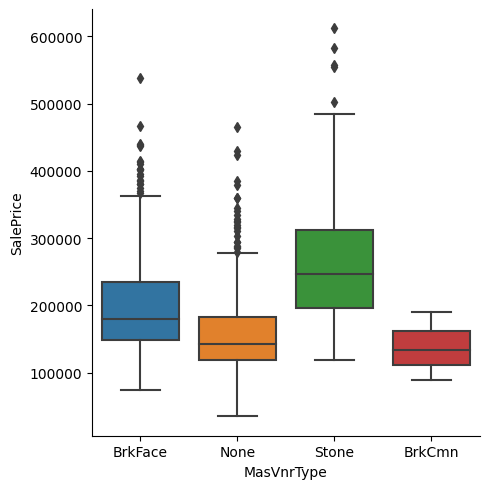

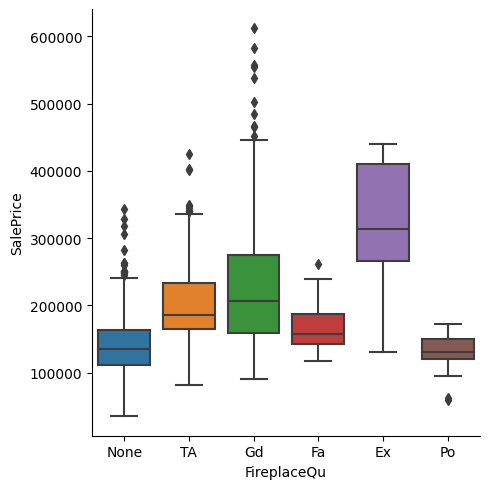

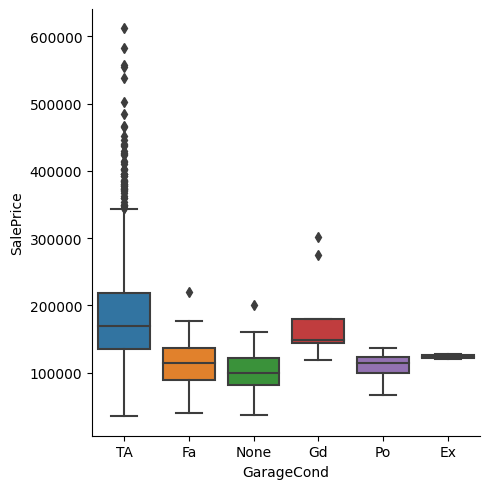

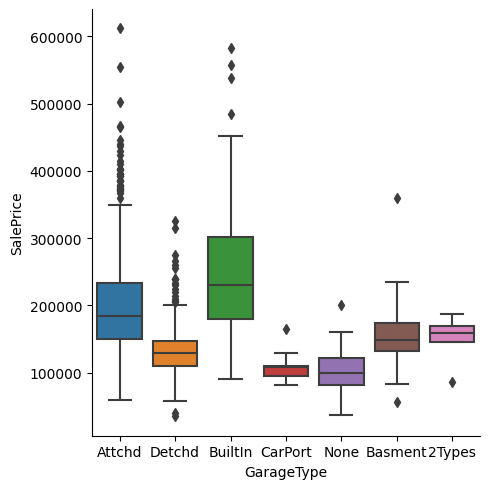

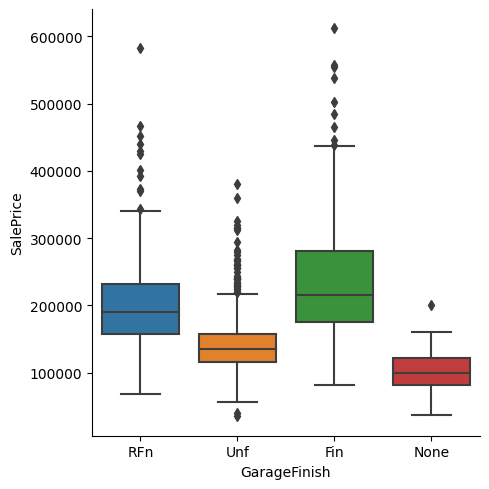

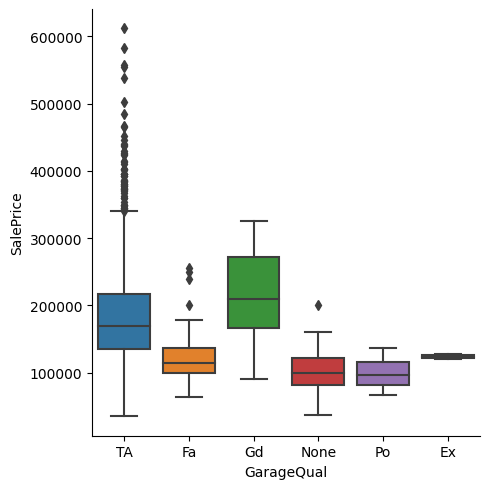

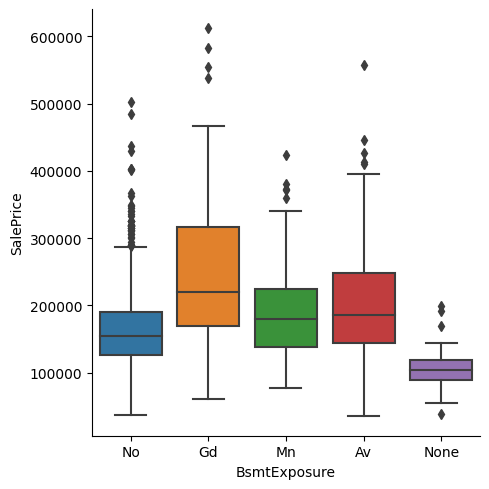

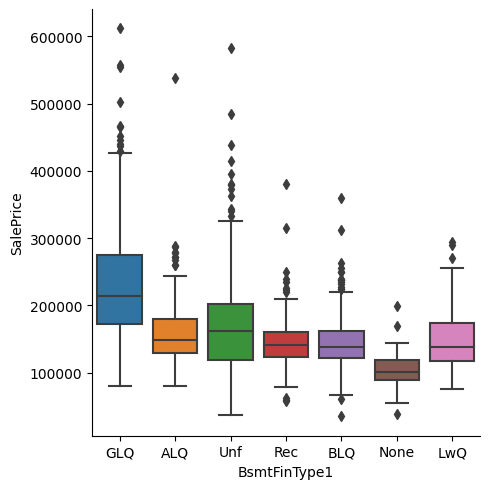

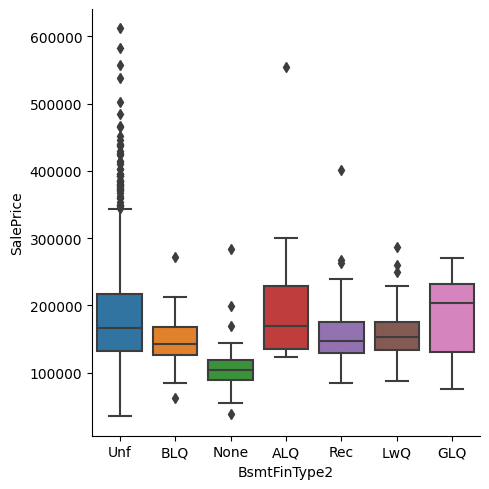

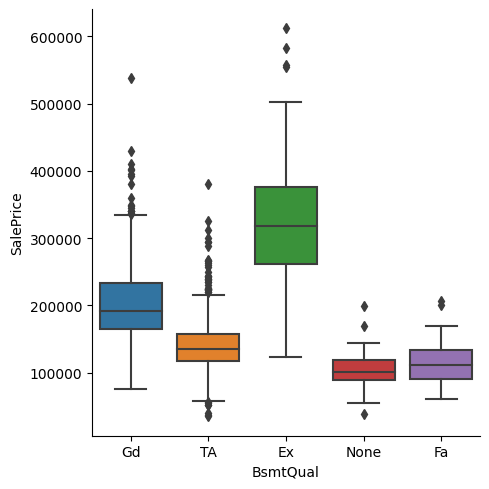

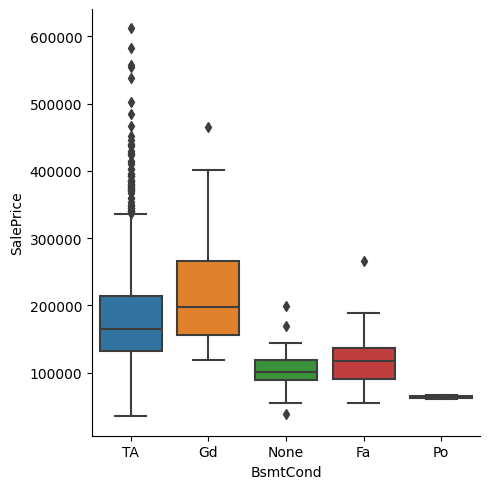

In [56]:
# Impute features and examine

for f in features:
    train_df[f] = train_df[f].fillna('None')
    test_df[f] = test_df[f].fillna('None')
    sns.catplot(data=train_df, x=f, y="SalePrice", kind="box")

In [57]:
# GarageCond and BsmtFinType2 don't show much variance in values, can drop

train_df.drop(columns=['GarageCond','BsmtFinType2'], inplace=True)
test_df.drop(columns=['GarageCond','BsmtFinType2'], inplace=True)

In [58]:
# Let's look at MasVnrArea
# From the documentation there looks to be a related feature MasVnrArea, which relates to the area of masonry veneer
# There are 8 nulls here from above, let's see what they look like

train_df[train_df['MasVnrArea'].isnull() == True][['MasVnrType','MasVnrArea']]



/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,MasVnrType,MasVnrArea
234,None,NaN
529,None,NaN
650,None,NaN
936,None,NaN
973,None,NaN
977,None,NaN
1243,None,NaN
1278,None,NaN


In [59]:
# These correspond to with MasVnrType=None, so MasVnrArea should be 0 here

train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(0)

LotFrontage mean:  69.32910321489001
LotFrontage median:  69.0


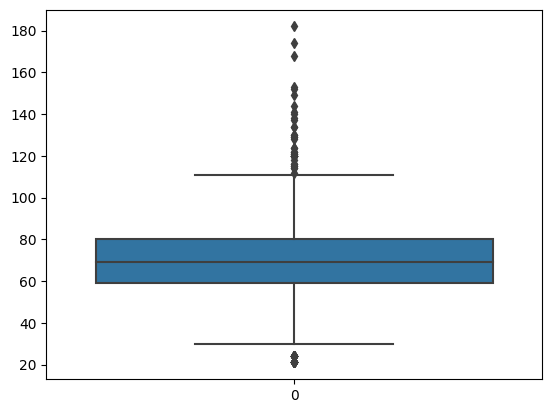

In [60]:
# Let's look at LotFrontage in more detail

sns.boxplot(train_df['LotFrontage'])
print('LotFrontage mean: ', np.nanmean(train_df['LotFrontage']))
print('LotFrontage median: ', np.nanmedian(train_df['LotFrontage']))

In [61]:
# Mean and median aren't too different, but let;s impute with median either way

train_df['LotFrontage'] = train_df['LotFrontage'].fillna(np.nanmedian(train_df['LotFrontage']))
test_df['LotFrontage'] = test_df['LotFrontage'].fillna(np.nanmedian(train_df['LotFrontage']))

GarageYrBlt mean:  1978.5022026431718
GarageYrBlt median:  1980.0


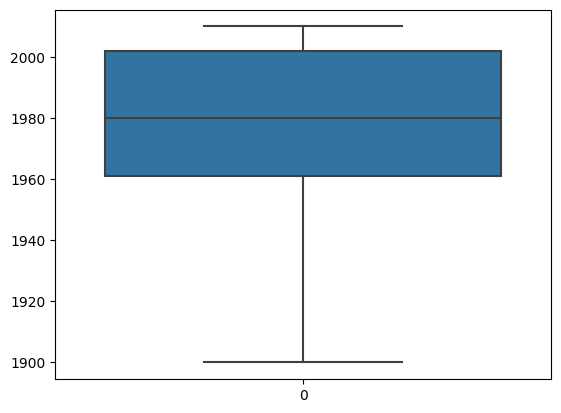

In [62]:
# Let's look at GarageYrBlt in more detail

sns.boxplot(train_df['GarageYrBlt'])
print('GarageYrBlt mean: ', np.nanmean(train_df['GarageYrBlt']))
print('GarageYrBlt median: ', np.nanmedian(train_df['GarageYrBlt']))

In [63]:
# This correlates heavily with Year built, hence we can drop it actually

print('Correlation of year built and garage year built: ', train_df['GarageYrBlt'].corr(train_df['YearBuilt']))

Correlation of year built and garage year built:  0.8268807416715879


In [64]:
# Drop column

train_df.drop(columns='GarageYrBlt', inplace=True)
test_df.drop(columns='GarageYrBlt', inplace=True)

In [65]:
# Finally we have Electrical. Na doesn't mean None in the documentation here

train_df['Electrical'].value_counts()

Electrical
SBrkr    1315
FuseA      91
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

In [66]:
# Let's impute with the most common value here

train_df['Electrical'] = train_df['Electrical'].fillna('SBrkr')

In [67]:
# Let's see final state of nulls

print('Number of nulls in training set', train_df.isnull().sum().sum())
print('Number of nulls in test set', test_df.isnull().sum().sum())

Number of nulls in training set 0
Number of nulls in test set 22


We have some nulls in the test set still, let's see what they are

In [68]:
nulls_test = pd.DataFrame(test_df.isnull().sum(), columns=['column'])
nulls_test = nulls_test[nulls_test['column'] > 0].sort_values(by='column', ascending=False)
nulls_test

,column
MSZoning,4
Utilities,2
BsmtFullBath,2
BsmtHalfBath,2
Functional,2
Exterior1st,1
Exterior2nd,1
BsmtFinSF1,1
BsmtFinSF2,1
BsmtUnfSF,1


In [69]:
# A number of these are numerical where NA can easily mean 0, so let's look at these

features_test_zero = ['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','GarageArea','GarageCars']
for f in features_test_zero:
    test_df[f] = test_df[f].fillna(0)
    

In [70]:
# The documentation of "Functional" says "(Assume typical unless deductions are warranted)"
# So we can impute with Typ

test_df["Functional"] = test_df["Functional"].fillna('Typ')

In [71]:
# Which ones do we have left

nulls_test = pd.DataFrame(test_df.isnull().sum(), columns=['column'])
nulls_test = nulls_test[nulls_test['column'] > 0].sort_values(by='column', ascending=False)
nulls_test

,column
MSZoning,4
Utilities,2
Exterior1st,1
Exterior2nd,1
KitchenQual,1
SaleType,1


The rest are categorical where for ease of use we can go with whatever the most frequent value is in the training dataset

In [72]:
cat_features_test = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']

for f in cat_features_test:
    test_df[f] = test_df[f].fillna(train_df[f].mode().values[0])

nulls_test = pd.DataFrame(test_df.isnull().sum(), columns=['column'])
nulls_test = nulls_test[nulls_test['column'] > 0].sort_values(by='column', ascending=False)
nulls_test

,column


# Feature Engineering

In [73]:
# We can take the year built, year sold - and combine to make a feature of the age at sale

train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']

# train_df.drop(columns=['YrSold', 'YearBuilt'], inplace=True)
# test_df.drop(columns=['YrSold', 'YearBuilt'], inplace=True)

In [74]:
# We can take the year remodeled, year sold - and combine to make a feature of the age at remodeling

train_df['HouseRemodelAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['HouseRemodelAge'] = test_df['YrSold'] - test_df['YearRemodAdd']

In [75]:
# We can add the square feet of all the floors together to create TotalSF

train_df['TotalSf'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['TotalSf'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']

In [76]:
# We can use GrLivArea and TotalBsmtSF to make Total Area

train_df['TotalArea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['TotalArea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']

In [77]:
# We can sum together the number of baths

train_df['TotalBaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath']) 
test_df['TotalBaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath']) 

In [78]:
# The total Porch SF areas can be added together

train_df['TotalPorchSF'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['TotalPorchSF'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']

In [79]:
# Let's now drop ID, and the other columns we made redundant in feature engineering

train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

In [80]:
print(train_df.shape)
print(test_df.shape)

(1438, 61)
(1459, 61)


<Axes: >

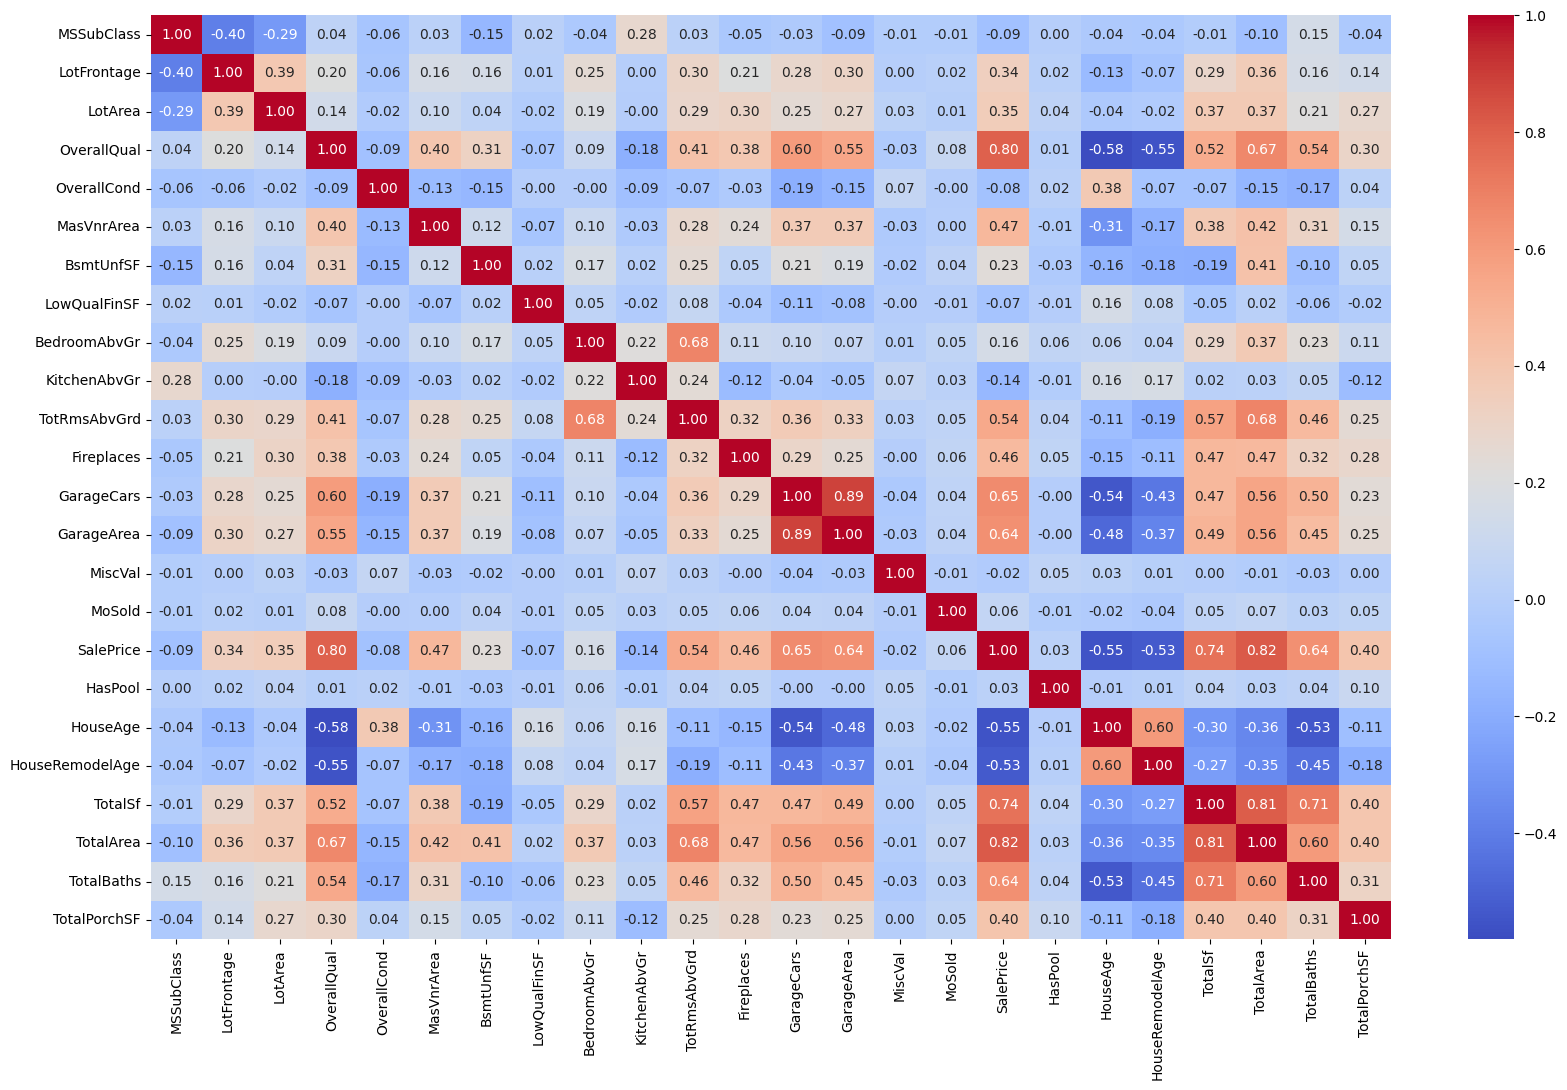

In [81]:
# Let's have a final look at the numerical columns and see whether there are any with high enough correlations to drop

correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [82]:
# Out of GarageCars and Garage Area, let's drop one of them
# GarageCars has a slightly higher correlation with salesprice

train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

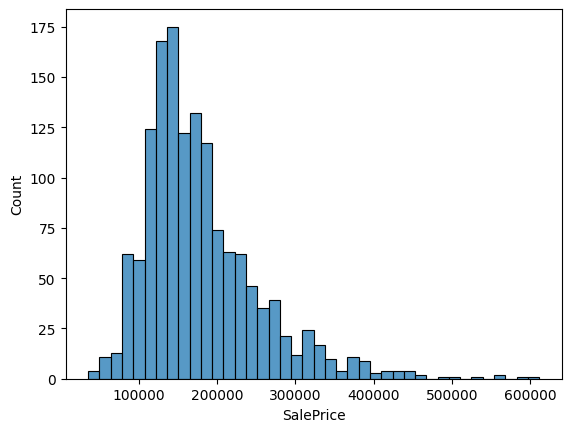

In [83]:
# We can see that the data is quite skewed

sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [84]:
# In version 2 we will try taking the log of the houseprice and see where we get to

train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

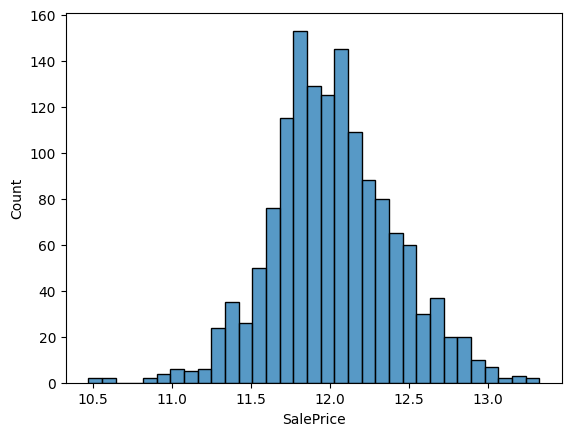

In [85]:
# Now we're all lovely and gaussian

sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

# Final Preprocessing

In [86]:
# Let's look at our categorical columns, decide which ones to one hot encode and ordinal encode

train_df.dtypes[train_df.dtypes=='object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [87]:
# Columns for ordinal encoding

ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [88]:
# Columns for one hot encoding

ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl','HasPool']

In [89]:
# Look at non object columns

train_df.dtypes[train_df.dtypes !='object']

MSSubClass           int64
LotFrontage        float64
LotArea              int64
OverallQual          int64
OverallCond          int64
MasVnrArea         float64
BsmtUnfSF            int64
LowQualFinSF         int64
BedroomAbvGr         int64
KitchenAbvGr         int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageCars           int64
MiscVal              int64
MoSold               int64
SalePrice          float64
HasPool               bool
HouseAge             int64
HouseRemodelAge      int64
TotalSf              int64
TotalArea            int64
TotalBaths         float64
TotalPorchSF         int64
dtype: object

In [90]:
# Define numerical columns

num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')
num_cols


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'LowQualFinSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MiscVal',
       'MoSold', 'HouseAge', 'HouseRemodelAge', 'TotalSf', 'TotalArea',
       'TotalBaths', 'TotalPorchSF'],
      dtype='object')

In [91]:
# Define preprocessing of numerical columns

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [92]:
# Define preprocessing of ordinal encoding columns

ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


In [93]:
# Define preprocessing of OHC columns

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [94]:
# Combining together with ColumnTransformer

col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [95]:
# Define pipeline

pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [96]:
# Split train_df into X, y

X = train_df.drop(columns='SalePrice')
y = train_df['SalePrice']

In [97]:
# Split data into training and cross validation datasets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Apply transformations to X_train, X_test

X_train_pp = pipeline.fit_transform(X_train)
X_val_pp = pipeline.transform(X_val)

# Model Building

In [99]:
# Build RF Model

rf_Model = RandomForestRegressor()

In [100]:
# Declare hyperparameters

param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [101]:
# Initialise GridSearchCV

rf_Grid = GridSearchCV(rf_Model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

In [102]:
# Fit model

rf_Grid.fit(X_train_pp, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [103]:
# What are our best parameters

rf_Grid.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 250}

In [104]:
rf_Grid.score(X_train_pp, y_train)

-0.002349896030293062

In [105]:



print (f'Train Accuracy - : {np.sqrt(-1*rf_Grid.score(X_train_pp, y_train)):.3f}')
print (f'Cross Validation Accuracy - : {np.sqrt(-1*rf_Grid.score(X_val_pp, y_val)):.3f}')

Train Accuracy - : 0.048
Cross Validation Accuracy - : 0.160


# Predict

In [106]:
df_test_preprocess = pipeline.transform(test_df)

In [107]:
predictions = np.exp(rf_Grid.predict(df_test_preprocess))

In [108]:
predictions

array([127521.45156879, 170228.64923217, 181021.35563573, ...,
       165342.40427828, 114747.49924763, 222630.66795907])

In [109]:
output = pd.DataFrame({'Id': test_df.Id, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,127521.451569
1,1462,170228.649232
2,1463,181021.355636
3,1464,189270.659071
4,1465,192191.917280
